In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


C:\Users\shaza\AppData\Local\Temp\ipykernel_11212\625149390.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [16]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "./drive/My Drive/Colab Notebooks/" # You may need to change this, depending on where your notebooks are on Google Drive
else:
  base_dir = "../" # You may need to change this, depending on where your datasets folder is
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

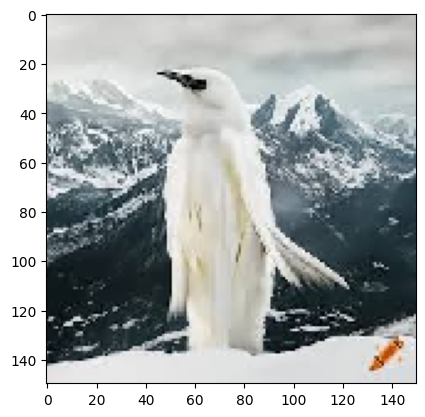

In [14]:
train_birds_dir = os.path.join(train_dir, "birds")
filenames = [os.path.join(train_birds_dir, filename) for filename in os.listdir(train_birds_dir)]
idx = 25 # Change this if you want to look at a different dog
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

In [17]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(224, 224))

Found 100 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


In [18]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
convnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                        

In [20]:

convnet_history = convnet.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

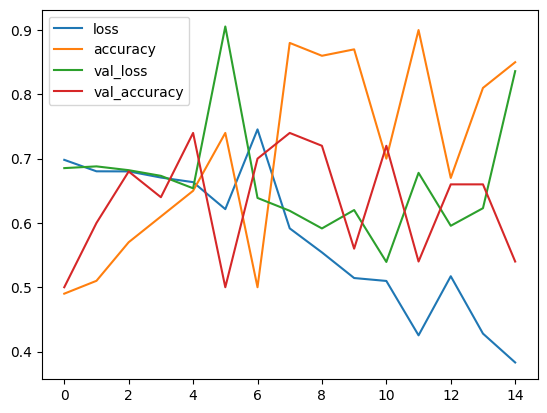

In [21]:
pd.DataFrame(convnet_history.history).plot()

With so few examples, overfitting is a major concern.
We know all sorts of things we can try in order to reduce the overfitting.
We'll add a dropout layer below.
Another way to reduce overfitting is to get more examples but here we do something similar: data augmentation.
We augment the training set with examples that we synthesize from the existing training set.
It's relatively easy when the dataset consists of images to use transformations on existing images to synthesize believable-looking new images.
Be aware that this is not as good as additional real examples.
These synthesized examples are correlated with each other and the originals from which they were generated.
In Keras, we add various layers to perform data augmentation.
These layers will only augment the training data, not the validation or test data.

In [53]:
augmentation_layers = Sequential([
   Input(shape=(224, 224, 3)),
   RandomFlip(mode="horizontal"),
   RandomRotation(factor=0.1),
   RandomZoom(height_factor=(-0.2, 0.2)),
   RandomTranslation(height_factor=0.2, width_factor=0.2)
])

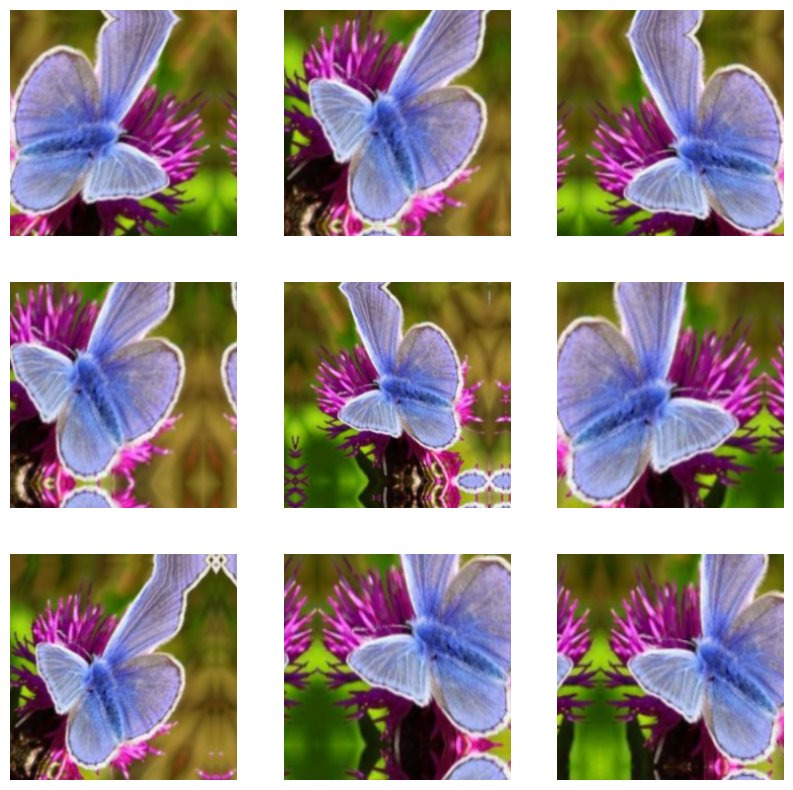

In [54]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [55]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
x = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
x = Rescaling(scale=1./255)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
augmented_model = Model(inputs, outputs)
augmented_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [56]:
augmented_model_history = augmented_model.fit(train_dataset, epochs=60,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

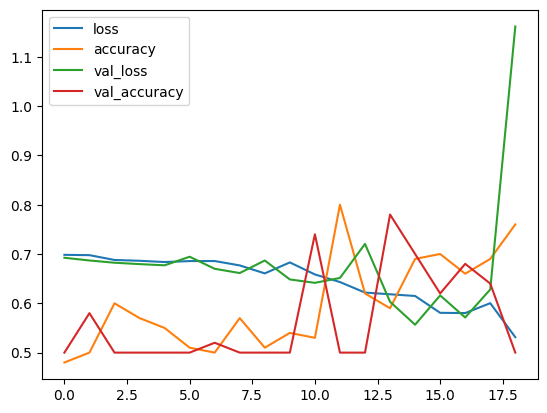

In [57]:
pd.DataFrame(augmented_model_history.history).plot()

In [32]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 7s 0us/step


In [33]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [34]:
resnet50 = ResNet50(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

102967424/102967424 [==============================] - 7s 0us/step


In [35]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [38]:
demo_dataset = image_dataset_from_directory(
    directory=os.path.join(base_dir, "ai1/datasets/dataset_wikipedia_images"), shuffle=False, label_mode=None, image_size=(224, 224), )

Found 4 files belonging to 1 classes.


In [40]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
transfer_model = Model(inputs=inputs, outputs=outputs)

In [41]:
resnet50_base.trainable = False

In [42]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1003

In [43]:
transfer_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [44]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

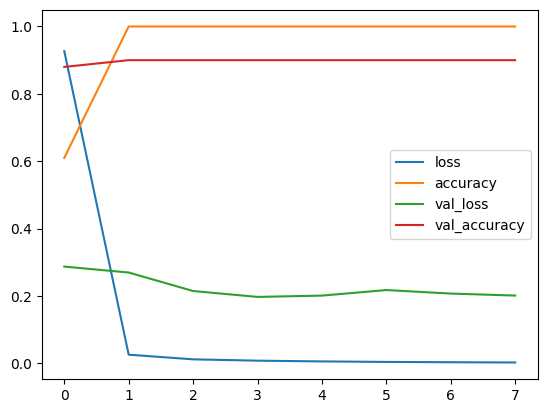

In [45]:
pd.DataFrame(transfer_model_history.history).plot()

In [46]:
for layer in resnet50_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [47]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1003

In [48]:
transfer_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [49]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

<Axes: >

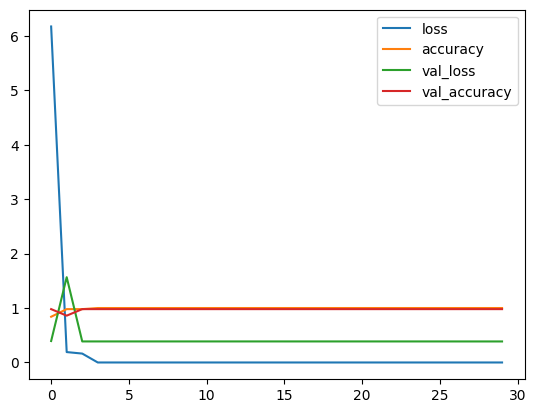

In [50]:
pd.DataFrame(transfer_model_history.history).plot()


In [51]:
# The original convnet
test_loss, test_acc = convnet.evaluate(test_dataset)
test_acc

2/2 [==============================] - 1s 343ms/step - loss: 0.5231 - accuracy: 0.7600


0.7599999904632568

In [58]:
# The convnet with dropout, trained using data augmentation
test_loss, test_acc = augmented_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 1s 354ms/step - loss: 0.5380 - accuracy: 0.7800


0.7799999713897705

In [59]:
# The convnet that was trained and tuned using transfer learning
test_loss, test_acc = transfer_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 3s 922ms/step - loss: 0.0055 - accuracy: 1.0000


1.0